In [61]:
# %load_ext autoreload
# %autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
from amwag.app_utilities.preprocessing import *
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt

from sklearn import set_config
set_config(transform_output="pandas")

RSEED = 5

In [62]:
df = pd.read_csv("../data/AQUASTAT_complete.csv", index_col=0)

pre-split preprocessing

In [63]:
pre_split_processor = get_pre_split_processor()

In [64]:
df_pre = pre_split_processor.transform(df)
df_pre.shape

(8575, 41)

limit years here!

In [65]:
df_pre = df_pre.query("year > 2000")

In [66]:
targets = ['gdp_per_capita', 'water_stress', 'total_population_with_access_to_safe_drinking_water']
df_targets = df_pre[["country", "year"] + targets]
df_targets.isna().sum()

country                                                 0
year                                                    0
gdp_per_capita                                          0
water_stress                                           69
total_population_with_access_to_safe_drinking_water     0
dtype: int64

In [67]:
df_targets.groupby("country").apply(lambda group: group.fillna(method="bfill")).isna().sum() # only early years are missing in water_stress

country                                                0
year                                                   0
gdp_per_capita                                         0
water_stress                                           0
total_population_with_access_to_safe_drinking_water    0
dtype: int64

In [68]:
# df_targets.to_csv("../data/targets_over_years.csv")

In [69]:
# df_pre.drop(columns=targets).to_csv("../data/features_over_years.csv")

In [70]:
df_ts = df_pre.sort_values("year").set_index("year")

In [71]:
#df_ts.index = pd.to_datetime(df_ts.index, format="%Y")

In [72]:
df_ts

,country,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2001,Afghanistan,44.702708,100.000000,11.875440,20.000000,30.613807,98.518576,54.063068,7753.0000,92.979179,...,47.150,2182.164400,21606.988,32.0,10.650,3023.558860,20.300740,939.545114,4648.139,18.18
2001,Belgium,NaN,100.000000,28.358991,0.037200,0.203279,0.521242,1.109350,865.8000,13.983887,...,12.000,1162.901241,10319.019,100.0,0.900,1773.424392,7.136800,691.616131,10028.603,6.30
2001,Mauritius,NaN,100.000000,46.568627,0.467840,17.006184,72.160428,5.887679,95.0000,56.427708,...,2.751,2304.180274,1193.917,99.3,0.893,2304.180274,0.648333,543.030490,508.114,0.00
2001,Mauritania,24.845746,52.400577,0.448239,1.430750,12.550439,93.078099,24.868960,462.0000,185.020722,...,0.400,148.016578,2702.400,43.3,0.300,4218.472469,1.537150,568.809207,1077.677,11.00
2001,United Kingdom of Great Britain and Northern I...,NaN,100.000000,23.406264,1.833000,1.246939,12.079873,0.782121,5702.0000,89.159636,...,145.000,2452.460823,59124.288,100.0,9.800,2486.287869,15.174000,256.645797,46580.884,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,Guatemala,24.809144,100.000000,18.780421,1.886000,1.474474,56.737162,10.243420,2045.0000,25.890338,...,109.200,6095.257488,17915.568,92.8,33.700,7139.600598,3.324100,185.542540,9284.293,18.71
2020,Greece,43.051419,100.000000,24.402547,8.107000,11.852339,80.092867,4.230805,3220.1601,1182.187102,...,58.000,5564.587884,10423.054,100.0,10.300,6562.376056,10.122000,971.116527,8850.409,10.40
2020,Philippines,34.760355,94.812910,37.250000,67.830825,14.160924,78.995084,10.184808,11175.0000,64.837836,...,479.000,4371.192625,109581.078,91.8,180.000,4371.192625,85.867147,783.594655,52008.603,0.00


In [73]:
df_imp = df_ts.groupby("country").apply(lambda group: group.interpolate())
df_imp = df_imp.apply(lambda group: group.fillna(method="ffill"))

In [74]:
df_imp.isna().sum().sum()

0

In [75]:
df_imp = df_imp.drop("country", axis=1).reset_index().set_index("year")

In [76]:
for c in df_ts.country.unique():
    df_1 = df_ts.query("country == @c")
    if df_1.isna().sum().sum() > 10:
        print(c)

Mauritius
United Kingdom of Great Britain and Northern Ireland
Malta
Luxembourg
Lithuania
Bhutan
Latvia
Lao People's Democratic Republic
Kuwait
Jordan
Philippines
Peru
Azerbaijan
Paraguay


Panama
Palestine
Bahrain
Oman
North Macedonia
Bangladesh
Barbados
United Arab Emirates
Nepal
Belarus
Norway
Puerto Rico
Ethiopia
Canada
Egypt
Central African Republic
Yemen
Chad
Chile
Croatia
Costa Rica
Comoros
Democratic People's Republic of Korea
Finland
Israel
Iraq
Indonesia
Iceland
Honduras
Guyana
Burundi
Germany
Gambia
Cambodia
Qatar
Switzerland
Australia
Turkmenistan
Rwanda
Thailand
Sri Lanka
Republic of Korea
Slovenia
Timor-Leste
Saudi Arabia
South Sudan


In [77]:
df_1 = df_ts.query("country == 'Chad'")
df_1.isna().sum().sum()

40

In [78]:
df_int = df_1.drop("country", axis=1).interpolate(axis=1)
df_int.isna().sum().sum()

0

In [79]:
df_int.head()

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2001,0.958824,16.910839,3.060748,0.637253,1.394427,77.682243,36.605330,3930.0,1998.588621,67.177243,...,15.0,1728.498715,8678.051,45.2,11.5,5266.159418,0.820333,94.529674,1877.232,30.7
2002,0.990247,17.135515,2.904984,0.672200,1.470897,78.039380,34.445495,3730.0,1898.588621,67.177243,...,15.0,1663.112595,9019.233,45.7,11.5,5066.949706,0.861360,95.502578,1953.584,30.7
2003,0.990247,17.135515,2.982866,0.672200,1.470897,77.492391,40.159436,3830.0,1948.588621,67.177243,...,15.0,1600.185024,9373.916,46.2,11.5,4875.230373,0.867440,92.537633,2032.953,30.7
2004,0.990247,17.135515,2.982866,0.672200,1.470897,76.953018,28.339881,3830.0,1948.588621,67.177243,...,15.0,1540.868929,9734.767,46.7,11.5,4694.514003,0.873520,89.731988,2113.721,30.7
2005,0.990247,17.135515,3.060748,0.672200,1.470897,76.421101,25.757433,3930.0,1998.588621,67.177243,...,15.0,1485.643778,10096.633,47.2,11.5,4526.261378,0.879600,87.118151,2194.746,30.7


modeling

In [80]:
def fit_variable(train_var):
    holt_winters = Holt(train_var)
    return holt_winters.fit()

def predict_variable(model, pred_time):
    return model.forecast(pred_time[1] - pred_time[0] + 1)

def get_const_columns(df):
    unique_values = df.nunique()
    constant_columns = unique_values[unique_values == 1].index.tolist()
    return constant_columns

In [81]:
#creating the train and validation set
train = df_int.query("index < 2018")
valid = df_int.query("index >= 2018")

In [82]:
pd.to_datetime(train.index, format="%Y")

DatetimeIndex(['2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2017-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

In [83]:
train.index = pd.to_datetime(train.index, format="%Y")
valid.index = pd.to_datetime(valid.index, format="%Y")

# const_cols = get_const_columns(train)
# train = train.drop(columns=const_cols)
# valid = valid.drop(columns=const_cols)

In [84]:
prediction_time_frame = (2018, 2020)
model_dict = {}
pred_df = pd.DataFrame({"year": np.arange(prediction_time_frame[0], prediction_time_frame[1]+1, 1)})
pred_df.set_index("year", inplace=True)
pred_df.index = pd.to_datetime(pred_df.index, format="%Y")

for var in train.columns.tolist():

    # fit model and get prediction
    var_model = fit_variable(train[var])
    var_pred = predict_variable(var_model, prediction_time_frame)

    # write results into dictionaries
    model_dict[var] = var_model
    pred_df[var] = var_pred.values

In [85]:
valid

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.990247,17.135515,4.079439,0.6722,1.470897,76.421101,32.442121,5238.0,2652.588621,67.177243,...,15.0,969.134425,15477.729,50.8,11.5,2952.629549,0.8796,56.830043,3540.279,30.7
2019-01-01,0.990247,17.135515,4.079439,0.6722,1.470897,76.421101,31.123508,5238.0,2652.588621,67.177243,...,15.0,940.623104,15946.876,50.8,11.5,2865.765056,0.8796,55.158139,3681.488,30.7
2020-01-01,0.990247,17.135515,4.079439,0.6722,1.470897,76.421101,31.436945,5238.0,2652.588621,67.177243,...,15.0,913.193973,16425.864,50.8,11.5,2782.197637,0.8796,53.549695,3830.260,30.7


In [86]:
pred_df

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.990247,17.135516,4.071154,0.672200,1.470897,76.421101,35.664665,5227.362441,2647.269803,67.177243,...,15.0,962.831527,15455.098223,50.803744,11.5,2933.427000,0.879598,56.720689,3527.846596,30.7
2019-01-01,0.990248,17.135519,4.063350,0.672200,1.470898,76.421100,37.487027,5217.343052,2642.260073,67.177243,...,15.0,927.587100,15893.774660,50.807487,11.5,2826.049268,0.879596,54.879925,3650.403273,30.7
2020-01-01,0.990248,17.135522,4.055546,0.672201,1.470900,76.421100,39.309390,5207.323664,2637.250344,67.177243,...,15.0,892.342672,16332.451096,50.811231,11.5,2718.671536,0.879594,53.039161,3772.959949,30.7


In [87]:
cols = train.columns.tolist()
#check rmse
for e, i in enumerate(cols):
    # print(e, i)
    # display(pred[i])
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred_df[i], valid[i])))

rmse value for %_of_agricultural_gva_produced_by_irrigated_agriculture is :  4.7667737519787824e-07
rmse value for %_of_agricultural_water_managed_area_equipped_for_irrigation is :  4.661740355124576e-06
rmse value for %_of_total_country_area_cultivated is :  0.01730489544711331
rmse value for agricultural_water_withdrawal is :  5.301269759614962e-07
rmse value for agricultural_water_withdrawal_as_%_of_total_renewable_water_resources is :  1.5840683202339192e-06
rmse value for agricultural_water_withdrawal_as_%_of_total_water_withdrawal is :  7.3622993600064e-09
rmse value for agriculture_value_added_%_gdp is :  6.13336651676806
rmse value for cultivated_area_arable_land_plus_permanent_crops is :  22.21789618839955
rmse value for dam_capacity_per_capita is :  11.109027666605705
rmse value for dependency_ratio is :  0.0
rmse value for gdp_per_capita is :  137.40035987302812
rmse value for groundwater_accounted_inflow is :  0.0
rmse value for groundwater_entering_the_country_total is :  

In [88]:
train.shape

(17, 39)

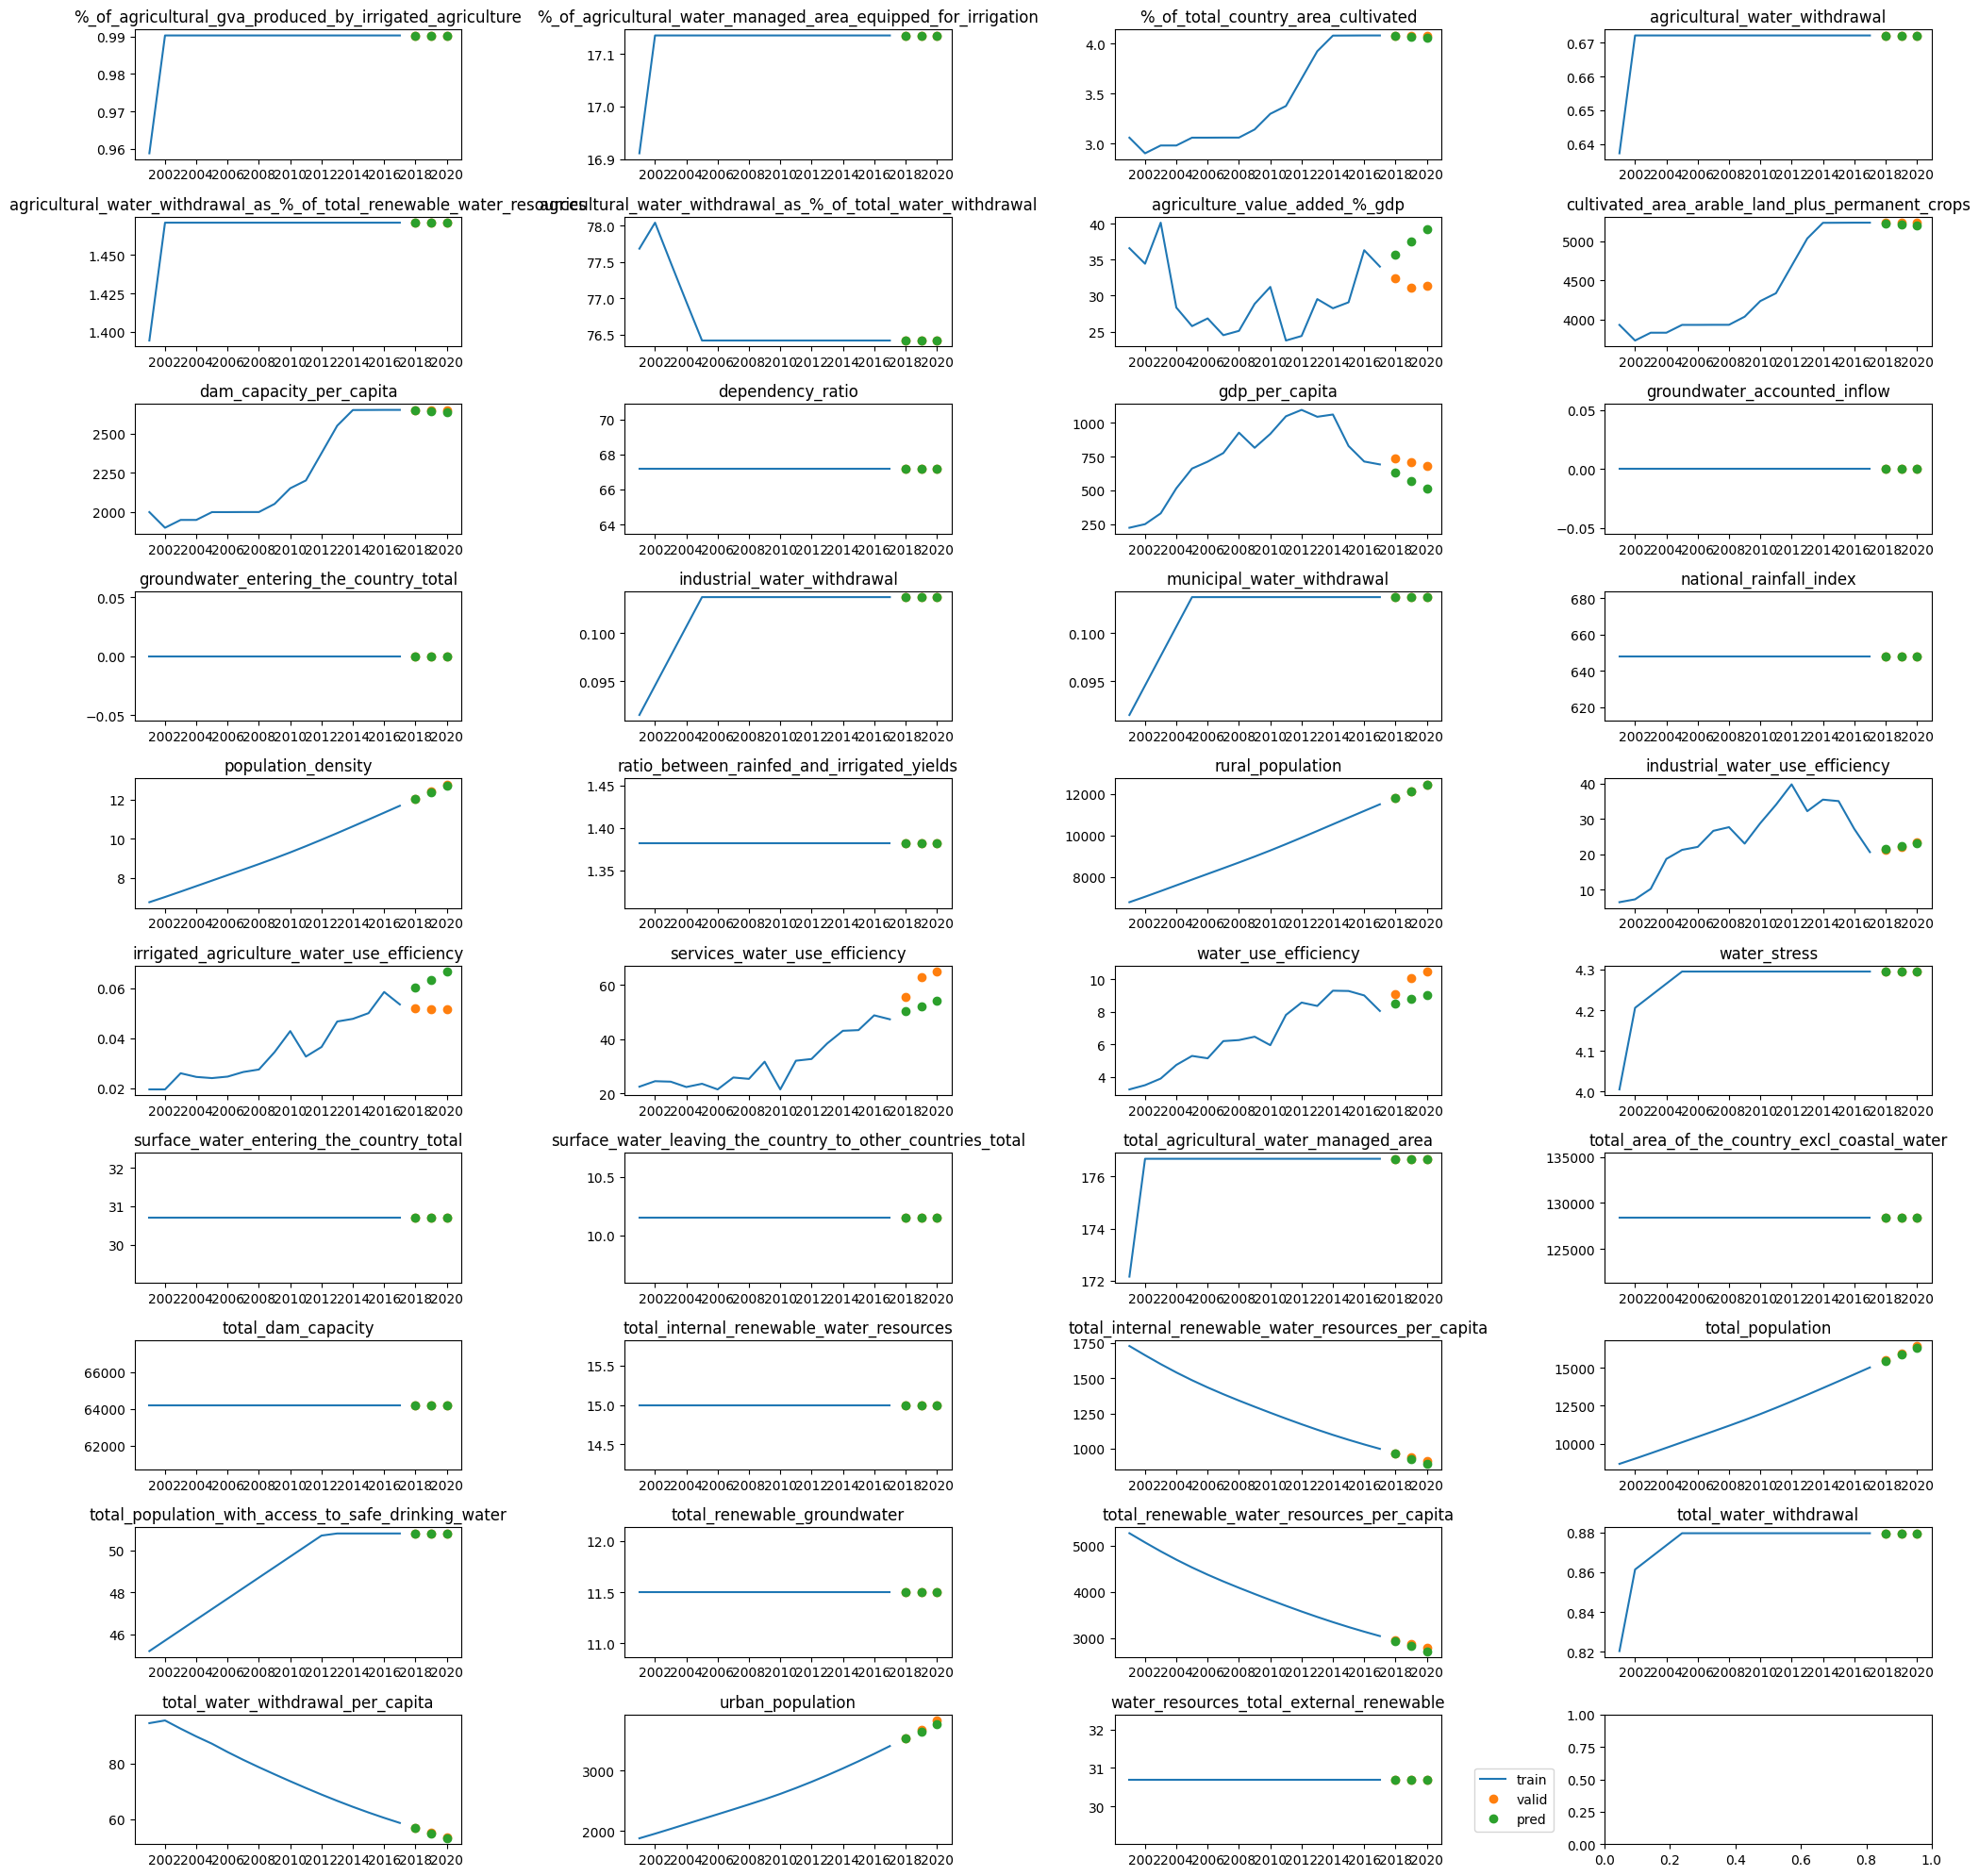

In [89]:
fig, axs = plt.subplots(10, 4, figsize=(20,20))
cols = valid.columns.tolist()

for i, ax in enumerate(axs.flat):
    if i<=train.shape[1]-1:
        ax.plot(train[cols[i]], label="train")
        ax.plot(valid[cols[i]], 'o', label="valid")
        ax.plot(pred_df[cols[i]], 'o', label="pred")
        ax.set_title(cols[i])
    if i==train.shape[1]-1:
        ax.legend(loc=(1.1, 0.1))
fig.tight_layout()

training for app

In [90]:
def fit_country(df):
    vars_dict = {}
    for var in df.columns.tolist():
        vars_dict[var] = fit_variable(df[var])
    return vars_dict

In [91]:
import warnings
warnings.filterwarnings("ignore")

In [92]:
# forecast_models_dict = {}

# for c in df_ts.country.unique():
#     df_c = df_ts.query("country == @c")
#     df_c = df_c.drop("country", axis=1).interpolate(axis=1)
#     df_c = df_c.fillna(method='bfill')
#     forecast_models_dict[c] = fit_country(df_c)

In [93]:
# with open("../ts_forecast_models.pkl", "wb") as file:
#     pkl.dump(forecast_models_dict, file)

In [94]:
import cProfile, pstats, io


def profile(fnc):
    
    """A decorator that uses cProfile to profile a function. 
       Starts the profile before executing a function, then exeuctes the function,
       then stops the profile, then prints out a diagnostics report.
       
       Lots of boilerplate code from the Python 3 documentation:
       https://docs.python.org/3/library/profile.html#profile.Profile
       """
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable() ### start the profiler
        
        retval = fnc(*args, **kwargs) ### then actually execute the function
        
        pr.disable() ### then we stop the profiler
        
        ###then print the results to the standard output
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        
        ### then return the actual return value of the inner function we executed
        return retval

    ### execute the innter function
    return inner

In [95]:
used_columns = ['country', 'year',
       '%_of_agricultural_gva_produced_by_irrigated_agriculture',
       '%_of_agricultural_water_managed_area_equipped_for_irrigation',
       '%_of_total_country_area_cultivated', 'agricultural_water_withdrawal',
       'agricultural_water_withdrawal_as_%_of_total_renewable_water_resources',
       'agricultural_water_withdrawal_as_%_of_total_water_withdrawal',
       'agriculture_value_added_%_gdp',
       'cultivated_area_arable_land_plus_permanent_crops',
       'dam_capacity_per_capita', 'dependency_ratio', 'gdp_per_capita',
       'groundwater_accounted_inflow',
       'groundwater_entering_the_country_total', 'industrial_water_withdrawal',
       'municipal_water_withdrawal', 'national_rainfall_index',
       'population_density', 'ratio_between_rainfed_and_irrigated_yields',
       'rural_population', 'industrial_water_use_efficiency',
       'irrigated_agriculture_water_use_efficiency',
       'services_water_use_efficiency', 'water_use_efficiency', 'water_stress',
       'surface_water_entering_the_country_total',
       'surface_water_leaving_the_country_to_other_countries_total',
       'total_agricultural_water_managed_area',
       'total_area_of_the_country_excl_coastal_water', 'total_dam_capacity',
       'total_internal_renewable_water_resources',
       'total_internal_renewable_water_resources_per_capita',
       'total_population',
       'total_population_with_access_to_safe_drinking_water',
       'total_renewable_groundwater',
       'total_renewable_water_resources_per_capita', 'total_water_withdrawal',
       'total_water_withdrawal_per_capita', 'urban_population',
       'water_resources_total_external_renewable']

In [96]:
@profile
def forecast_dataset(model_dict, used_columns, n_years):
    df = pd.DataFrame(columns=used_columns)
    for i, (c, vm_dict) in enumerate(model_dict.items()):
        #print(c, vm_dict)
        c_forecasts = {v: m.forecast(n_years) for v, m in vm_dict.items()}

        df_c = pd.DataFrame(c_forecasts)

        df_c.insert(0, "year", [2020 + n+1 for n in range(n_years)])
        df_c.insert(0, "country", [c]*n_years)
        df = pd.concat([df, df_c])

        #display(df_c)
        #if i == 3:  break

    #df.reset_index(inplace=True)
    return df


In [97]:
# fc = forecast_dataset(forecast_models_dict, used_columns, 5)

In [98]:
# fc.isna().sum()

In [99]:
# fc[["country","%_of_agricultural_gva_produced_by_irrigated_agriculture", "%_of_agricultural_water_managed_area_equipped_for_irrigation"]].loc[fc["%_of_agricultural_gva_produced_by_irrigated_agriculture"].isnull()]["country"].unique()

In [100]:
# df_ts.query("country == 'Belgium'")["%_of_agricultural_gva_produced_by_irrigated_agriculture"].to_frame().fillna(method='bfill')

In [101]:
# fc

In [102]:
# fc_targets = fc[["country", "year"] + targets]
# fc_targets.head(5)

In [103]:
#fc = fc.drop(columns=targets)

In [104]:
# with open("forecast_2021_2025.pkl", "wb") as file:
#     pkl.dump(fc, file)
# with open("forecast_2021_2025_targets.pkl", "wb") as file:
#     pkl.dump(fc_targets, file)

# fc.to_csv("../data/forecast_2021_2025.csv")
# fc_targets.to_csv("forecast_2021_2025_targets.csv")

test goodness

In [105]:
forecast_models_dict = {}
valid_dfs_dict = {}

for c in df_ts.country.unique():
    df_c = df_ts.query("country == @c")
    df_c = df_c.drop("country", axis=1).interpolate(axis=1)
    df_c = df_c.fillna(method='bfill')
    #creating the train and validation set
    train = df_c.query("index < 2017")
    valid = df_c.query("index >= 2017")

    train.index = pd.to_datetime(train.index, format="%Y")
    valid.index = pd.to_datetime(valid.index, format="%Y")

    forecast_models_dict[c] = fit_country(train)
    valid_dfs_dict[c] = valid

In [106]:
def forecast_dataset(model_dict, used_columns, n_years):
    df = pd.DataFrame(columns=used_columns)
    for i, (c, vm_dict) in enumerate(model_dict.items()):
        #print(c, vm_dict)
        c_forecasts = {v: m.forecast(n_years) for v, m in vm_dict.items()}

        df_c = pd.DataFrame(c_forecasts)

        df_c.insert(0, "year", [2016 + n+1 for n in range(n_years)])
        df_c.insert(0, "country", [c]*n_years)
        df = pd.concat([df, df_c])

    return df

In [107]:
fc = forecast_dataset(forecast_models_dict, used_columns, 4)

In [108]:
with open("country_forecast_dfs.pkl", "rb") as file:
    fc_multi = pkl.load(file)
#df_valid_multi = pd.read_csv("VAR_valid.csv")
with open("country_valid_dfs.pkl", "rb") as file:
    valid_multi = pkl.load(file)

In [109]:
fc_multi = {df.country.iloc[0]: df.drop("country", axis=1).set_index("year") for df in fc_multi}
# fc_multi

0 Afghanistan
1 Belgium
2 Mauritius
3 Mauritania
4 United Kingdom of Great Britain and Northern Ireland
5 Malta
6 Mali
7 Belize
8 Malaysia
9 Malawi
10 Madagascar
11 Luxembourg
12 Benin
13 Lithuania
14 Mexico
15 Libya
16 Lesotho
17 United Republic of Tanzania
18 Bhutan
19 Lebanon
20 Latvia
21 Lao People's Democratic Republic
22 Bolivia (Plurinational State of)
23 Kyrgyzstan
24 Kuwait
25 Kenya
26 Kazakhstan
27 Botswana
28 Jordan
29 Liberia
30 Japan
31 Mongolia
32 Mozambique
33 Austria
34 Portugal
35 Poland
36 Philippines
37 Peru
38 Azerbaijan
39 Paraguay
40 Panama
41 Ukraine
42 Palestine
43 Zimbabwe
44 Bahrain
45 Pakistan
46 Morocco
47 Oman
48 North Macedonia
49 Bangladesh
50 Nigeria
51 Niger
52 Nicaragua
53 New Zealand
54 Netherlands (Kingdom of the)
55 Barbados
56 United Arab Emirates
57 Nepal
58 Namibia
59 Myanmar
60 Belarus
61 Norway
62 Puerto Rico
63 United States of America
64 Zambia
65 Cameroon
66 Ethiopia
67 Eswatini
68 Estonia
69 Eritrea
70 Venezuela (Bolivarian Republic of)
71 

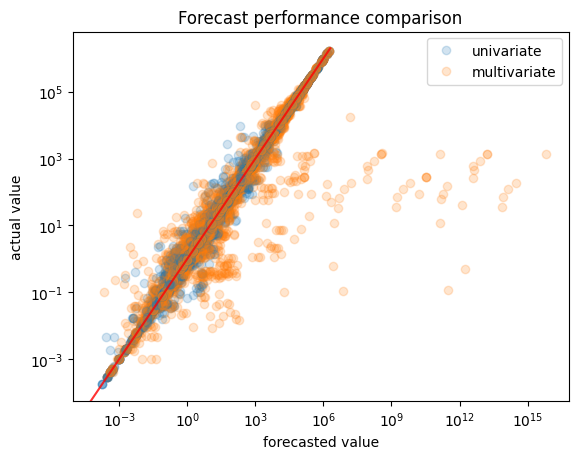

In [110]:
fig = plt.figure()
var_list = [var for var in fc.columns.tolist() if not var in ["year", "country"]]

for i, c in enumerate(fc.country.unique()):
    print(i, c)
    for j, var in enumerate(var_list):
        if i==0 and j==0:
            plt.plot(fc.query("country == @c")[var], valid_dfs_dict[c][var], "o", alpha=0.2, color="C0", label="univariate")
            plt.plot(fc_multi[c][var], valid_multi[c][var], "o", alpha=0.2, color="C1", label="multivariate")
        else:
            plt.plot(fc.query("country == @c")[var], valid_dfs_dict[c][var], "o", alpha=0.2, color="C0")
            plt.plot(fc_multi[c][var], valid_multi[c][var], "o", alpha=0.2, color="C1")
plt.plot([-10, 2e6], [-10, 2e6], color="red", alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.title("Forecast performance comparison")
plt.xlabel("forecasted value")
plt.ylabel("actual value")
plt.legend()

0 Afghanistan
1 Belgium
2 Mauritius
3 Mauritania
4 United Kingdom of Great Britain and Northern Ireland
5 Malta
6 Mali
7 Belize
8 Malaysia
9 Malawi
10 Madagascar
11 Luxembourg
12 Benin
13 Lithuania
14 Mexico
15 Libya
16 Lesotho
17 United Republic of Tanzania
18 Bhutan
19 Lebanon
20 Latvia
21 Lao People's Democratic Republic
22 Bolivia (Plurinational State of)
23 Kyrgyzstan
24 Kuwait
25 Kenya
26 Kazakhstan
27 Botswana
28 Jordan
29 Liberia
30 Japan
31 Mongolia
32 Mozambique
33 Austria
34 Portugal
35 Poland
36 Philippines
37 Peru
38 Azerbaijan
39 Paraguay
40 Panama
41 Ukraine
42 Palestine
43 Zimbabwe
44 Bahrain
45 Pakistan
46 Morocco
47 Oman
48 North Macedonia
49 Bangladesh
50 Nigeria
51 Niger
52 Nicaragua
53 New Zealand
54 Netherlands (Kingdom of the)
55 Barbados
56 United Arab Emirates
57 Nepal
58 Namibia
59 Myanmar
60 Belarus
61 Norway
62 Puerto Rico
63 United States of America
64 Zambia
65 Cameroon
66 Ethiopia
67 Eswatini
68 Estonia
69 Eritrea
70 Venezuela (Bolivarian Republic of)
71 

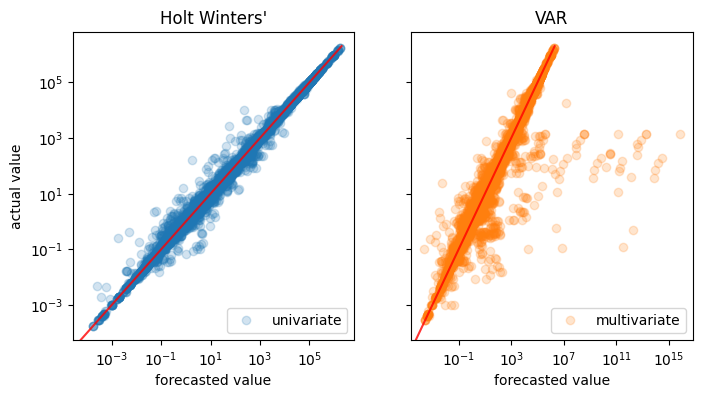

In [111]:
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
var_list = [var for var in fc.columns.tolist() if not var in ["year", "country"]]

for i, c in enumerate(fc.country.unique()):
    print(i, c)
    for j, var in enumerate(var_list):
        if i==0 and j==0:
            axs[0].plot(fc.query("country == @c")[var], valid_dfs_dict[c][var], "o", alpha=0.2, color="C0", label="univariate")
            axs[1].plot(fc_multi[c][var], valid_multi[c][var], "o", alpha=0.2, color="C1", label="multivariate")
        else:
            axs[0].plot(fc.query("country == @c")[var], valid_dfs_dict[c][var], "o", alpha=0.2, color="C0")
            axs[1].plot(fc_multi[c][var], valid_multi[c][var], "o", alpha=0.2, color="C1")
axs[0].plot([-10, 2e6], [-10, 2e6], color="red", alpha=0.8)
axs[1].plot([-10, 2e6], [-10, 2e6], color="red", alpha=0.8)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].set_title("Holt Winters'")
axs[1].set_title("VAR")
axs[0].set_xlabel("forecasted value")
axs[1].set_xlabel("forecasted value")
axs[0].set_ylabel("actual value")
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")

In [112]:
from sklearn.metrics import mean_absolute_percentage_error

In [113]:
mape_dict_uni = {var: [] for var in var_list} 
mape_dict_uni["country"] = []
for i, c in enumerate(fc.country.unique()):
    print(i, c)
    mape_dict_uni["country"].append(c)
    for j, var in enumerate(var_list):
        y_true = valid_dfs_dict[c][var]
        y_pred = fc.query("country == @c")[var]
        mape_dict_uni[var].append(mean_absolute_percentage_error(y_true, y_pred))

0 Afghanistan


1 Belgium
2 Mauritius
3 Mauritania
4 United Kingdom of Great Britain and Northern Ireland
5 Malta
6 Mali
7 Belize
8 Malaysia
9 Malawi
10 Madagascar
11 Luxembourg
12 Benin
13 Lithuania
14 Mexico
15 Libya
16 Lesotho
17 United Republic of Tanzania
18 Bhutan
19 Lebanon
20 Latvia
21 Lao People's Democratic Republic
22 Bolivia (Plurinational State of)
23 Kyrgyzstan
24 Kuwait
25 Kenya
26 Kazakhstan
27 Botswana
28 Jordan
29 Liberia
30 Japan
31 Mongolia
32 Mozambique
33 Austria
34 Portugal
35 Poland
36 Philippines
37 Peru
38 Azerbaijan
39 Paraguay
40 Panama
41 Ukraine
42 Palestine
43 Zimbabwe
44 Bahrain
45 Pakistan
46 Morocco
47 Oman
48 North Macedonia
49 Bangladesh
50 Nigeria
51 Niger
52 Nicaragua
53 New Zealand
54 Netherlands (Kingdom of the)
55 Barbados
56 United Arab Emirates
57 Nepal
58 Namibia
59 Myanmar
60 Belarus
61 Norway
62 Puerto Rico
63 United States of America
64 Zambia
65 Cameroon
66 Ethiopia
67 Eswatini
68 Estonia
69 Eritrea
70 Venezuela (Bolivarian Republic of)
71 Canada
72 El S

In [114]:
mape_dict_multi = {var: [] for var in var_list} 
mape_dict_multi["country"] = []
for i, c in enumerate(fc.country.unique()):
    print(i, c)
    mape_dict_multi["country"].append(c)
    for j, var in enumerate(var_list):
        y_true = valid_multi[c][var]
        y_pred = fc_multi[c][var]
        mape_dict_multi[var].append(mean_absolute_percentage_error(y_true, y_pred))

0 Afghanistan
1 Belgium
2 Mauritius
3 Mauritania
4 United Kingdom of Great Britain and Northern Ireland
5 Malta
6 Mali
7 Belize
8 Malaysia
9 Malawi
10 Madagascar
11 Luxembourg
12 Benin
13 Lithuania
14 Mexico
15 Libya
16 Lesotho
17 United Republic of Tanzania
18 Bhutan
19 Lebanon
20 Latvia
21 Lao People's Democratic Republic
22 Bolivia (Plurinational State of)
23 Kyrgyzstan
24 Kuwait
25 Kenya
26 Kazakhstan
27 Botswana
28 Jordan
29 Liberia
30 Japan
31 Mongolia
32 Mozambique
33 Austria
34 Portugal
35 Poland
36 Philippines
37 Peru
38 Azerbaijan
39 Paraguay
40 Panama
41 Ukraine
42 Palestine
43 Zimbabwe
44 Bahrain
45 Pakistan
46 Morocco
47 Oman
48 North Macedonia
49 Bangladesh
50 Nigeria
51 Niger
52 Nicaragua
53 New Zealand
54 Netherlands (Kingdom of the)
55 Barbados
56 United Arab Emirates
57 Nepal
58 Namibia
59 Myanmar
60 Belarus
61 Norway
62 Puerto Rico
63 United States of America
64 Zambia
65 Cameroon
66 Ethiopia
67 Eswatini
68 Estonia
69 Eritrea
70 Venezuela (Bolivarian Republic of)
71 

In [115]:
y_true

year
2017    33.8
2018    33.8
2019    33.8
2020    33.8
Name: water_resources_total_external_renewable, dtype: float64

In [122]:
df_mape_uni = pd.DataFrame(mape_dict_uni).set_index("country")
df_mape_multi = pd.DataFrame(mape_dict_multi).set_index("country")
df_mape_uni

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000960,0.000000,0.011911,0.000000,0.000000,3.478434e-07,0.102902,0.011925,0.026876,0.0,...,0.0,0.026876,0.002619,0.019023,0.0,0.026876,3.524711e-07,0.027041,0.003293,0.0
Belgium,0.346369,0.000000,0.045607,0.085807,0.085807,5.034078e-02,0.056869,0.045607,0.001680,0.0,...,0.0,0.001678,0.001162,0.000000,0.0,0.001678,9.219062e-02,0.104938,0.000533,0.0
Mauritius,0.029877,0.000000,0.015183,0.059705,0.059786,4.306116e-02,0.066741,0.015181,0.001890,0.0,...,0.0,0.000711,0.000714,0.000345,0.0,0.000711,5.456246e-02,0.058135,0.004297,0.0
Mauritania,0.000019,0.005089,0.004623,0.000032,0.000033,3.114162e-07,0.082284,0.004057,0.019411,0.0,...,0.0,0.019411,0.003535,0.003767,0.0,0.019411,2.539619e-05,0.011609,0.005414,0.0
United Kingdom of Great Britain and Northern Ireland,0.593149,0.000000,0.007237,0.135309,0.135332,7.324812e-02,0.183952,0.007237,0.001488,0.0,...,0.0,0.001488,0.001050,0.000000,0.0,0.001488,2.614945e-02,0.027841,0.000102,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tajikistan,0.005669,0.000000,0.039740,0.290888,0.290908,1.658923e-01,0.052277,0.039402,0.002094,0.0,...,0.0,0.001354,0.003977,0.004815,0.0,0.001350,1.502506e-01,0.156499,0.006665,0.0
Argentina,0.036326,0.000000,0.016504,0.000427,0.000419,7.487889e-05,0.097905,0.017083,0.002687,0.0,...,0.0,0.003701,0.001006,0.004295,0.0,0.003701,3.617521e-04,0.001651,0.000236,0.0
Türkiye,0.000000,0.000000,0.010980,0.096171,0.096169,1.552211e-02,0.158856,0.011103,0.002074,0.0,...,0.0,0.005517,0.002281,0.001250,0.0,0.005517,7.627695e-02,0.069148,0.001455,0.0


In [127]:
df_mape_uni[var_list].loc["Afghanistan"]

%_of_agricultural_gva_produced_by_irrigated_agriculture                  9.604464e-04
%_of_agricultural_water_managed_area_equipped_for_irrigation             0.000000e+00
%_of_total_country_area_cultivated                                       1.191064e-02
agricultural_water_withdrawal                                            0.000000e+00
agricultural_water_withdrawal_as_%_of_total_renewable_water_resources    0.000000e+00
agricultural_water_withdrawal_as_%_of_total_water_withdrawal             3.478434e-07
agriculture_value_added_%_gdp                                            1.029024e-01
cultivated_area_arable_land_plus_permanent_crops                         1.192542e-02
dam_capacity_per_capita                                                  2.687638e-02
dependency_ratio                                                         0.000000e+00
gdp_per_capita                                                           1.660515e-01
groundwater_accounted_inflow                          

In [132]:
from amwag.app_utilities.app_utilities import *

In [135]:
reverse_var_name_dict = create_reverse_var_name_dict(df_ts.reset_index())
nice_var_name_list = [reverse_var_name_dict[var] for var in var_list]
nice_var_name_list

['percentage of agricultural gva produced by irrigated agriculture',
 'percentage of agricultural water managed area equipped for irrigation',
 'percentage of total country area cultivated',
 'agricultural water withdrawal',
 'agricultural water withdrawal as percentage of total renewable water resources',
 'agricultural water withdrawal as percentage of total water withdrawal',
 'agriculture value added percentage gdp',
 'cultivated area arable land plus permanent crops',
 'dam capacity per capita',
 'dependency ratio',
 'gdp per capita',
 'groundwater accounted inflow',
 'groundwater entering the country total',
 'industrial water withdrawal',
 'municipal water withdrawal',
 'national rainfall index',
 'population density',
 'ratio between rainfed and irrigated yields',
 'rural population',
 'industrial water use efficiency',
 'irrigated agriculture water use efficiency',
 'services water use efficiency',
 'water use efficiency',
 'water stress',
 'surface water entering the country 

In [138]:
len(nice_var_name_list)

39

In [143]:
df_mape_multi.isna().sum().sum()

0

0 Afghanistan
1 Belgium
2 Mauritius
3 Mauritania
4 United Kingdom of Great Britain and Northern Ireland
5 Malta
6 Mali
7 Belize
8 Malaysia
9 Malawi
10 Madagascar
11 Luxembourg
12 Benin
13 Lithuania
14 Mexico
15 Libya
16 Lesotho
17 United Republic of Tanzania
18 Bhutan
19 Lebanon
20 Latvia
21 Lao People's Democratic Republic
22 Bolivia (Plurinational State of)
23 Kyrgyzstan
24 Kuwait
25 Kenya
26 Kazakhstan
27 Botswana
28 Jordan
29 Liberia
30 Japan
31 Mongolia
32 Mozambique
33 Austria
34 Portugal
35 Poland
36 Philippines
37 Peru
38 Azerbaijan
39 Paraguay
40 Panama
41 Ukraine
42 Palestine
43 Zimbabwe
44 Bahrain
45 Pakistan
46 Morocco
47 Oman
48 North Macedonia
49 Bangladesh
50 Nigeria
51 Niger
52 Nicaragua
53 New Zealand
54 Netherlands (Kingdom of the)
55 Barbados
56 United Arab Emirates
57 Nepal
58 Namibia
59 Myanmar
60 Belarus
61 Norway
62 Puerto Rico
63 United States of America
64 Zambia
65 Cameroon
66 Ethiopia
67 Eswatini
68 Estonia
69 Eritrea
70 Venezuela (Bolivarian Republic of)
71 

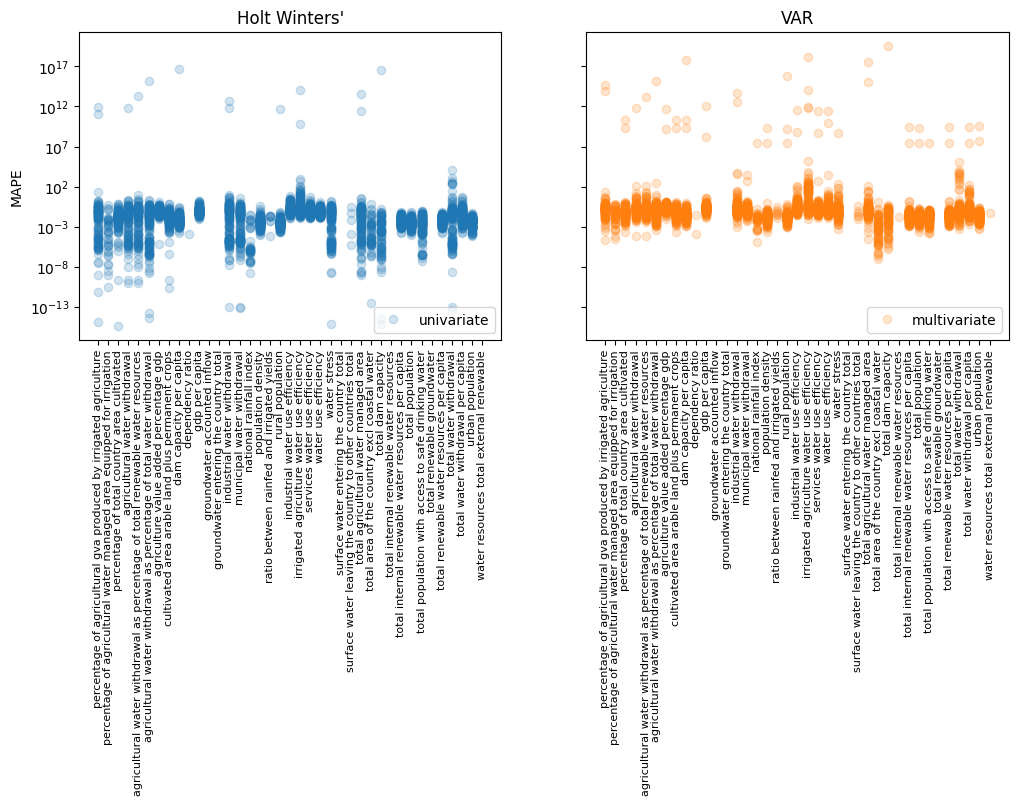

In [144]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)

for i, c in enumerate(fc.country.unique()):
    print(i, c)
    if i==0:
        axs[0].plot(nice_var_name_list, df_mape_uni[var_list].loc[c], "o", alpha=0.2, color="C0", label="univariate")
        axs[1].plot(nice_var_name_list, df_mape_multi[var_list].loc[c], "o", alpha=0.2, color="C1", label="multivariate")
    else:
        axs[0].plot(nice_var_name_list, df_mape_uni[var_list].loc[c], "o", alpha=0.2, color="C0")
        axs[1].plot(nice_var_name_list, df_mape_multi[var_list].loc[c], "o", alpha=0.2, color="C1")
axs[0].set_yscale("log")
axs[0].set_ylabel("MAPE")
axs[0].set_title("Holt Winters'")
axs[1].set_title("VAR")
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize=8)
fig.tight_layout()